<a href="https://colab.research.google.com/github/MichelangeloConserva/statistical-challenge/blob/main/predictive_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#@title Import

import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from scipy.stats import gaussian_kde, norm
from tqdm import trange

np.random.seed(42)

100%|██████████| 500/500 [00:03<00:00, 131.13it/s]


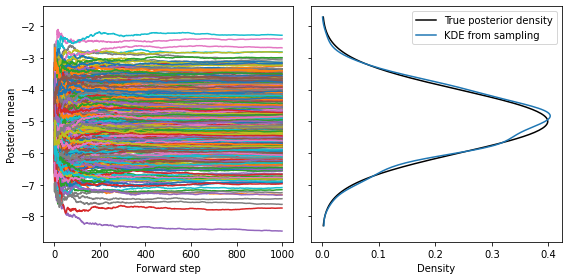

In [8]:
# @title Posterior sampling through sequential imputation
N = 1000  # @param {type:"slider", min:100, max:2000, step:10}
B = 500  # @param {type:"slider", min:100, max:2000, step:10}
observation_noise = 2  # @param {type:"slider", min:0.1, max:10, step:0.1}
initial_posterior_mean = -5  # @param {type:"slider", min:-10, max:10, step:0.5}
initial_posterior_sigma_squared = 1  # @param {type:"slider", min:0.1, max:10, step:0.1}

final_posterior_mean = []
posterior_mean_trajs = []
samples = []
for b in trange(B):
    n = 0
    theta_n = initial_posterior_mean
    sigma_squared_n = initial_posterior_sigma_squared
    y_b = []

    posterior_mean_traj = []
    for i in range(N):
        y = np.random.normal(theta_n, (observation_noise + sigma_squared_n) ** 0.5)
        y_b.append(y)
        n = len(y_b)
        sigma_squared_n = (
            1 / initial_posterior_sigma_squared + n / observation_noise
        ) ** -1
        theta_n = (
            initial_posterior_mean / initial_posterior_sigma_squared
            + sum(y_b) / observation_noise
        ) * sigma_squared_n
        posterior_mean_traj.append(theta_n)
    final_posterior_mean.append(posterior_mean_traj[-1])
    posterior_mean_trajs.append(posterior_mean_traj)
    samples.append(y_b)

fig, axes = plt.subplots(1, 2, figsize=plt.figaspect(0.5), sharey=True)
for t in posterior_mean_trajs:
    axes[0].plot(t)
axes[0].set_xlabel("Forward step")
axes[0].set_ylabel("Posterior mean")
nn = norm(initial_posterior_mean, initial_posterior_sigma_squared ** 0.5)
x = np.linspace(nn.ppf(0.0005), nn.ppf(1 - 0.0005), 200)
axes[1].set_xlabel("Density")
axes[1].plot(nn.pdf(x), x, color="black", label="True posterior density")
axes[1].plot(gaussian_kde(final_posterior_mean)(x), x, label="KDE from sampling")
plt.legend()
plt.tight_layout()
plt.show()

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


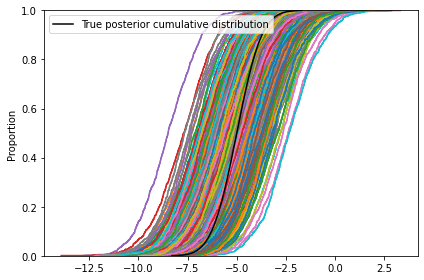

In [9]:
# @title Plotting empirical cumulative distribution obtained from imputing procedure
x = np.linspace(nn.ppf(0.0005), nn.ppf(1 - 0.0005), 200)
for y_b in samples:
    sns.ecdfplot(y_b)
plt.plot(x, nn.cdf(x), color="black", label="True posterior cumulative distribution")
plt.legend()
plt.tight_layout()
plt.show()

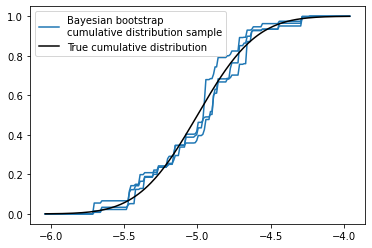

In [25]:
# @title Bayesian bootstrapping of normal distribution
N = 50  # @param {type:"slider", min:10, max:500, step:5}
mean = -5  # @param {type:"slider", min:-10, max:10, step:0.5}
sigma_squared = 0.1  # @param {type:"slider", min:0.1, max:10, step:0.1}
num_samples = 3  # @param {type:"slider", min:1, max:10, step:1}

# True samples
y_n = np.random.normal(mean, sigma_squared**0.5, N)

# Choosing points for plotting
nn = norm(mean, sigma_squared**0.5)
y = np.linspace(nn.ppf(0.0005), nn.ppf(1 - 0.0005), 200)

# BB samples
bb_samples = []
for _ in range(num_samples):
    w = np.random.dirichlet([1] * N)
    bb_sample = (w.reshape(-1, 1) * (y_n.reshape(-1, 1) <= y.reshape(1, -1))).sum(0)
    bb_samples.append(bb_sample)

for i, bb_sample in enumerate(bb_samples):
    plt.plot(
        y,
        bb_sample,
        label="Bayesian bootstrap\ncumulative distribution sample" if i == 0 else None,
        color="tab:blue",
    )
plt.plot(y, nn.cdf(y), color="black", label="True cumulative distribution")
plt.legend()
plt.show()
